# Homework 1: Q-Learning, DQN and Policy Gradient

This notebook will guide you through the homework assignment, which is divided into four main parts. Follow the instructions in each section carefully and complete the tasks as described. Submission is in pairs only.


** **bold text**Academic Integrity Reminder:** All homework submissions will be rigorously checked for plagiarism and AI-generated content. Submissions found to contain such content will not be accepted. You are encouraged to use materials from lectures and tutorials to aid your understanding and complete your assignments. However, copying complete solutions from the internet or any other sources is strictly prohibited. It is essential to demonstrate your own understanding and effort in your work. Maintaining academic integrity is crucial for your learning and development.

**Submission Guidlines:**

* Submission is in pairs only.
* Your answers should be in English.
* Each answer to the TODO items should clearly demonstrate your understanding of the topic. Be brief, as answers longer than 150 words will be penalized. Focus on delivering clear, accurate responses that reflect your knowledge of the material.
* You need to submit the completed IPython notebook (ipynb) that you run on a Google Colab instance with all cell outputs printed. You are allowed to run it on your local machine, but make sure that your submission will compile and produce results when run all on a clean runtime.
* You need to submit a PDF of the notebook along with the ipynb file. You can use the code at the end of this document to produce the required PDF.

## Preparation: Installing auxillary libraries and helper functions

First, we need to install the missing libraries. Just run the cells below.

In [ ]:
!pip install -q gymnasium

!pip install -q swig
!pip install -q gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Google Colab does not support dynamic rendering of the environment. We will define the function that will save a run as GIF, so we can display it.

In [ ]:
import os
from PIL import Image as PILImage

def save_run_as_gif(env, agent, max_steps_per_episode, filename):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    # Check if the file already exists
    if os.path.exists(filename):
        print(f"{filename} already exists. Skipping creation.")
        return

    frames = []
    state = env.reset(seed=42)[0]

    for step in range(max_steps_per_episode):
        frames.append(env.render())
        if hasattr(agent, 'q_table'):
            action = agent.act(state)
            if isinstance(env.action_space, gym.spaces.Box):
                action = agent.get_continuous_action(action)
        else:
            action = np.random.randint(env.action_space.n)

        next_state, reward, done, _, _ = env.step(action)
        state = next_state

        if done:
            break

    frames.append(env.render())
    env.close()

    frames = [PILImage.fromarray(frame) for frame in frames]
    frames[0].save(filename, save_all=True, append_images=frames[1:], loop=0, duration=200)


In [ ]:
import gymnasium as gym
import numpy as np

import time
from tqdm.notebook import tqdm
import os

from PIL import Image as PILImage
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [ ]:
# Set random seed
seed = 42
np.random.seed(seed)

# Part 1: Implement and Evaluate Q-Learning

## Quick Reminder from Tutorials

What is Q-learning? Q-learning is a model-free reinforcement learning algorithm used to find an action-selection policy for a given finite Markov decision process. It is a type of temporal difference learning where the agent learns to maximize the total reward by iteratively updating a Q-value function, which estimates the expected utility of taking a particular action in a given state and following the policy thereafter. The algorithm updates Q-values using the Bellman equation based on the immediate reward received and the maximum Q-value of the next state. By balancing exploration (trying new actions) and exploitation (choosing actions with the highest Q-values), Q-learning converges towards an optimal policy, enabling the agent to make the best decisions to achieve its goals.

## Objective
Implement the Q-learning algorithm and validate its performance on both discrete and continuous environments.

## Task Description
- Develop your own implementation of the Q-learning algorithm from scratch.
- Train your Q-learning agent using the Taxi-v3 environment and analyze its performance.
- Extend your Q-learning implementation to handle continuous environments by discretizing the state space.
- Train your Q-learning agent on the LunarLander-v2 and MountainCarContinuous-v0 environments, and evaluate its performance.
- Provide a comprehensive analysis with graphs showing the reward over training episodes and the convergence behavior.
- Discuss any performance differences observed across the environments, and explain potential reasons for these differences.

## Step-by-Step Implementation

Follow the steps below to implement the Q-learning algorithm. Fill in the TODO sections with your code.


## Step 1: Define the QLearningAgent Class

First, you need to define a class for the Q-learning agent. This class will contain methods for choosing actions, updating the Q-table, and managing exploration-exploitation trade-off.


In [ ]:
# (MARK)

import numpy as np
from tqdm.notebook import tqdm
import time

class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        self.state_size = state_size  # Number of possible states
        self.action_size = action_size  # Number of possible actions
        self.alpha = alpha  # Replace with learning rate
        self.gamma = gamma  # Replace with discount factor
        self.epsilon = epsilon  # Replace with initial exploration rate
        self.epsilon_min = epsilon_min  # Replace with minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Replace with decay rate of exploration

        # Initialize Q-table with zeros
        self.q_table = np.zeros((state_size, action_size))

    def act(self, state):
        """
        Choose an action based on the current state using epsilon-greedy policy.
        """
        if np.random.rand() < self.epsilon:
          return np.random.randint(self.action_size) # Explore: select a random action
        else:
          return np.argmax(self.q_table[state]) # Exploit: select the action with max value (greedy)

    def learn(self, state, action, reward, next_state, done):
        """
        Update the Q-table based on the agent's experience.
        """
        # TODO: Implement the Q-learning update rule
        current_q = self.q_table[state, action]
        target_q = reward + (self.gamma * np.max(self.q_table[next_state]) if done == False else 0)
        self.q_table[state, action] += self.alpha * (target_q - current_q)

    def update_epsilon(self):
        """
        Decay the exploration rate (epsilon) after each episode.
        """
        # TODO: Implement the epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def train(self, env, num_episodes=1000, max_steps_per_episode=100, update_interval=5):
        """
        Train the Q-learning agent in the given environment.
        """
        rewards_all_episodes = []
        start_time = time.time()
        last_update_time = start_time

        progress_bar = tqdm(total=num_episodes, desc="Training Progress", unit="episode")

        for episode in range(num_episodes):
            state = env.reset()[0]
            total_rewards = 0

            # TODO: Implement the training loop for each episode
            for step in range(max_steps_per_episode):
              # Complete the training loop here
              action = self.act(state)
              next_state, reward, done, _, _ = env.step(action)
              self.learn(state, action, reward, next_state, done)
              state = next_state
              total_rewards += reward

              if done:
                break

            # TODO: Call the update_epsilon method to decay epsilon
            self.update_epsilon()
            rewards_all_episodes.append(total_rewards)
            progress_bar.update(1)

            # Update progress information every update_interval seconds
            current_time = time.time()
            if current_time - last_update_time >= update_interval:
                elapsed_time = current_time - start_time
                remaining_time = (elapsed_time / (episode + 1)) * (num_episodes - episode - 1)
                progress_bar.set_postfix({
                    "Elapsed Time": f"{elapsed_time:.2f}s",
                    "Remaining Time": f"{remaining_time:.2f}s"
                })
                last_update_time = current_time

        progress_bar.close()
        return rewards_all_episodes

## Step 2: Run Q-Learning on Taxi-v3 Environment

Now we will train our Q-learning agent on the Taxi-v3 environment. Taxi-v3 is a simple environment where the agent needs to pick up and drop off passengers at the correct locations.

### Taxi-v3 Environment

The Taxi-v3 environment is part of the Toy Text environments in Gymnasium. The task involves navigating a 5x5 grid to pick up and drop off passengers at one of four designated locations: Red, Green, Yellow, and Blue. The taxi starts at a random position, and the passenger starts at one of the designated locations.

#### Action Space
- Discrete(6):
  - 0: Move south (down)
  - 1: Move north (up)
  - 2: Move east (right)
  - 3: Move west (left)
  - 4: Pickup passenger
  - 5: Drop off passenger

#### Observation Space
- Discrete(500): Represents all possible states combining taxi positions, passenger locations, and destinations.

#### Rewards
- -1 per step unless other reward is triggered.
- +20 for delivering the passenger to the correct location.
- -10 for illegal pickup or drop-off actions.

#### Episode End
- The episode ends when the passenger is successfully dropped off.
- The episode truncates if it exceeds 200 steps.

#### Additional Information
For detailed documentation, visit [Taxi-v3 Documentation](https://www.gymlibrary.dev/environments/toy_text/taxi/).

**Initialize the Environment and Agent**

First, we need to initialize the Taxi-v3 environment and create an instance of our QLearningAgent.



array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]], dtype=uint8)
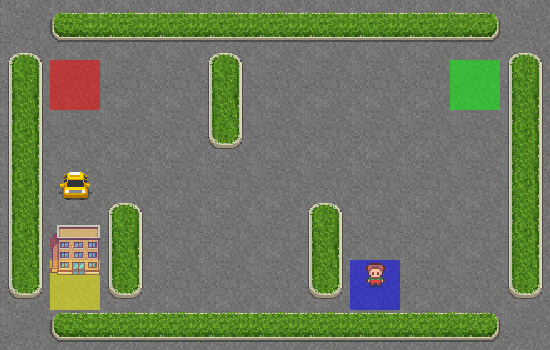

In [ ]:
import gymnasium as gym
import numpy as np


env = gym.make('Taxi-v3', render_mode='rgb_array')
env.reset(seed=seed)

state_size = env.observation_space.n
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

env.reset()
env.render()

Let's check how an untrained agent behaves:

Untrained Agent's Run:


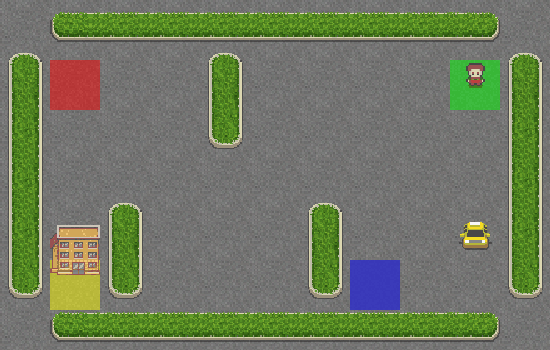

In [ ]:
from IPython.display import Image, display
if os.path.exists('data/untrained_taxi_q_agent.gif'):
  os.remove('data/untrained_taxi_q_agent.gif')
save_run_as_gif(env, agent, max_steps_per_episode=100, filename='data/untrained_taxi_q_agent.gif')

print("Untrained Agent's Run:")
display(Image(filename='data/untrained_taxi_q_agent.gif'))

**Train the Agent**

We will now train our Q-learning agent by calling the train method. You can check the training progress on the progress bar.

In [ ]:
#TODO: Try to play with different training parameters
num_episodes = 5000
max_steps_per_episode = 200

rewards_all_episodes = agent.train(env, num_episodes, max_steps_per_episode)
print("Training finished.")

Training Progress:   0%|          | 0/5000 [00:00<?, ?episode/s]

Training finished.


**Evaluate the Agent**

After training, we can evaluate the performance of our Q-learning agent by running it for a few episodes and observing the rewards.

In [ ]:
num_eval_episodes = 100
rewards_eval_episodes = []

for episode in range(num_eval_episodes):
    state = env.reset()[0]
    total_rewards = 0

    for step in range(max_steps_per_episode):
        action = np.argmax(agent.q_table[state])  # Always exploit in evaluation
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_rewards += reward

        if done:
            break

    rewards_eval_episodes.append(total_rewards)

average_reward = np.mean(rewards_eval_episodes)
print(f"Average reward over {num_eval_episodes} episodes: {average_reward}")

Average reward over 100 episodes: 8.33


**Plot the Training Rewards**

Finally, we will plot the rewards over the training episodes to visualize the learning progress.

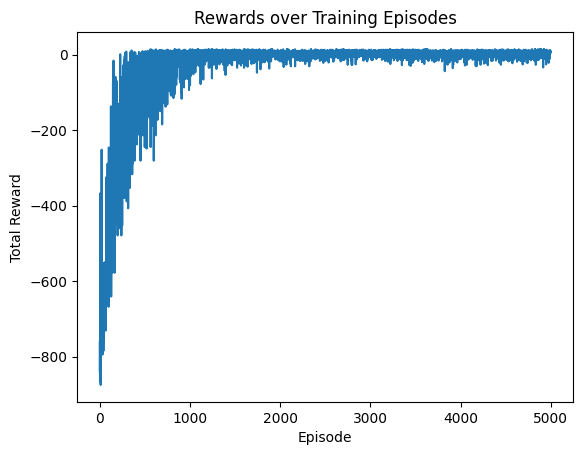

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Training Episodes')
plt.show()

Now we can plot a run of a trained agent. Do you think it behaves reasonably? Give your answer below in the TODO block.

Trained Agent's Run:


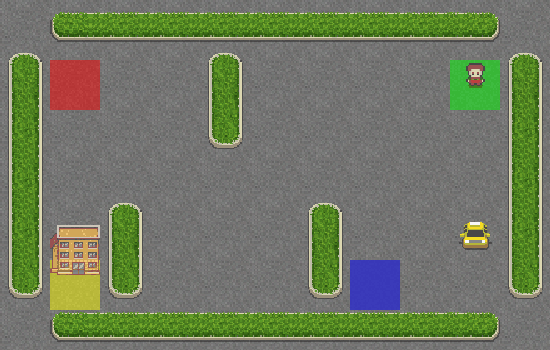

In [ ]:
if os.path.exists('/data/trained_taxi_q_agent.gif'):
  os.remove('/data/trained_taxi_q_agent.gif')
save_run_as_gif(env, agent, max_steps_per_episode=100, filename='/data/trained_taxi_q_agent.gif')

print("Trained Agent's Run:")
display(Image(filename='/data/trained_taxi_q_agent.gif'))

(MARK) **TODO:** Your answer here

## Step 3: Define the QLearningAgent Class for a Continious Domain

In this step, we will address the challenge of working with continuous environments. Continuous environments require discretization of the state space to apply the Q-learning algorithm effectively. We will define a new class `QLearningAgentDiscrete` to handle this discretization and train our agent on the `MountainCarContinuous-v0` and `LunarLander-v2` environment.

### Handling Continuous Environments

Continuous environments present a challenge for Q-learning because the state space is infinite. To apply Q-learning, we need to discretize the continuous state space into a finite number of bins. This allows us to use a Q-table to store and update the Q-values for each discrete state-action pair.

### Steps to Implement Q-Learning in Continuous Environments

1. **Discretize the State Space:** Convert the continuous state space into a finite number of bins. Each continuous state will be mapped to a discrete state represented by a bin index.
2. **Define the Q-Learning Agent Class:** Extend the Q-learning agent to handle the discretized state space. Implement methods for discretizing states, choosing actions, updating the Q-table, and training the agent.
3. **Map Discrete Actions to Continuous Actions:** Define a mapping from discrete actions to continuous actions. This is necessary because the action space in continuous environments is also infinite.


In [ ]:
# (MARK)

import gymnasium as gym
import numpy as np
import time
from tqdm.notebook import tqdm
import os
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from IPython.display import Image, display

class QLearningAgentDiscrete:
    def __init__(self, env, bins=(10, 10), alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995):
        # Initialize discretization parameters
        self.env = env
        self.bins = bins
        self.alpha = alpha  # Replace with learning rate
        self.gamma = gamma  # Replace with discount factor
        self.epsilon = epsilon  # Replace with initial exploration rate
        self.epsilon_min = epsilon_min  # Replace with minimum exploration rate
        self.epsilon_decay = epsilon_decay  # Replace with decay rate of exploration

        # Define discrete state space
        self.state_bins = [np.linspace(low, high, num=bins[i]) for i, (low, high) in enumerate(zip(env.observation_space.low, env.observation_space.high))] # TODO: Create an array of bins for each state dimension to discretize the state space

        # Check if the action space is discrete or continuous
        if isinstance(env.action_space, gym.spaces.Discrete):
            self.action_space_type = "discrete"
            self.q_table = np.zeros(bins + (env.action_space.n,))
        elif isinstance(env.action_space, gym.spaces.Box):
            self.action_space_type = "continuous"
            num_action_bins = 20
            self.action_bins = np.linspace(env.action_space.low[0], env.action_space.high[0], num_action_bins)  # TODO: Define action bins for continuous actions
            self.q_table = np.zeros(bins + (num_action_bins,))  # TODO: Initialize Q-table for continuous actions

    def discretize_state(self, state):
        """Convert continuous state to discrete state."""
        state_idx = []
        # TODO: Convert each dimension of the state to its corresponding bin index
        for i, dim in enumerate(state):
            state_idx.append(np.digitize(dim, self.state_bins[i]) - 1)
        return tuple(state_idx)  # Return as a tuple to use as an index
        # return tuple(np.digitize(s, b) - 1 for s, b in zip(state, self.state_bins))


    def act(self, state):
        """Choose an action based on the current state using epsilon-greedy policy."""
        # TODO: Implement epsilon-greedy action selection
        discrete_state = self.discretize_state(state)
        if np.random.rand() < self.epsilon:
          if self.action_space_type == "continuous":
            return np.random.randint(len(self.action_bins))
            # return np.random.choice(self.action_bins)
          else:
            return self.env.action_space.sample() # Explore: select a random action
        else:
          return np.argmax(self.q_table[discrete_state]) # Exploit: select the action with max value (greedy)

    def learn(self, state, action, reward, next_state, done):
        """Update the Q-table based on the agent's experience."""
        # TODO: Implement Q-learning update rule
        discrete_state = self.discretize_state(state) # TODO: Discretize the current state
        discrete_next_state = self.discretize_state(next_state) # TODO: Discretize the next state

        if self.action_space_type == "continuous":
            discrete_action = np.digitize(action[0], self.action_bins) - 1 # TODO: Handle learning for continuous action space
        else:
            discrete_action = action  # TODO: Handle learning for discrete action space

        current_q = self.q_table[discrete_state + (discrete_action,)]
        target_q = current_q + self.alpha * (reward + self.gamma * np.max(self.q_table[discrete_next_state]) - current_q)
        self.q_table[discrete_state + (discrete_action,)] = target_q

    def update_epsilon(self):
        """Decay the exploration rate (epsilon) after each episode."""
        # TODO: Implement epsilon decay logic
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def get_continuous_action(self, discrete_action):
        """Map discrete action to a continuous action."""
        return [self.action_bins[discrete_action]]  # TODO: Map discrete action to a continuous action

    def train(self, num_episodes=1000, max_steps_per_episode=100, update_interval=5):
        """
        Train the Q-learning agent in the given environment.
        """
        rewards_all_episodes = []
        start_time = time.time()
        last_update_time = start_time

        progress_bar = tqdm(total=num_episodes, desc="Training Progress", unit="episode")

        for episode in range(num_episodes):
            state = self.env.reset(seed=seed)[0]
            total_rewards = 0

            for step in range(max_steps_per_episode):
                # TODO: Complete the training loop here
                action = self.act(state)
                if self.action_space_type == "continuous":
                  action = self.get_continuous_action(action)
                next_state, reward, done, _, _ = self.env.step(action)
                self.learn(state, action, reward, next_state, done)
                state = next_state
                total_rewards += reward

                if done:
                    break

            # TODO: Call the update_epsilon method to decay epsilon
            self.update_epsilon()
            rewards_all_episodes.append(total_rewards)
            progress_bar.update(1)

            # Update progress information every update_interval seconds
            current_time = time.time()
            if current_time - last_update_time >= update_interval:
                elapsed_time = current_time - start_time
                remaining_time = (elapsed_time / (episode + 1)) * (num_episodes - episode - 1)
                progress_bar.set_postfix({
                    "Elapsed Time": f"{elapsed_time:.2f}s",
                    "Remaining Time": f"{remaining_time:.2f}s"
                })
                last_update_time = current_time

        progress_bar.close()
        return rewards_all_episodes


## Step 4: Run Q-Learning on LunarLander Environment
To compare your Q-learning implementation with a pre-implemented Q-learning agent from Stable Baselines3 (SB3), train and evaluate your agent on the LunarLander environment.

Training:

In [ ]:
# Create the LunarLander environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Set random seed
seed = 42
np.random.seed(seed)
env.reset(seed=seed)

# Define the Q-learning agent with discretization for continuous state space
agent = QLearningAgentDiscrete(env, bins=(10, 10, 10, 10, 10, 10, 10, 10))

# Train the agent

#TODO: Try to play with different training parameters
num_episodes = 10000
max_steps_per_episode = 200

rewards_all_episodes = agent.train(num_episodes=num_episodes, max_steps_per_episode=max_steps_per_episode)
print("Training finished.")


Training Progress:   0%|          | 0/10000 [00:00<?, ?episode/s]

In [ ]:

# Evaluate the agent
num_eval_episodes = 100
rewards_eval_episodes = []

for episode in range(num_eval_episodes):
    state = env.reset()[0]
    total_rewards = 0

    for step in range(max_steps_per_episode):
        action = np.argmax(agent.q_table[agent.discretize_state(state)])  # Always exploit in evaluation
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_rewards += reward

        if done:
            break

    rewards_eval_episodes.append(total_rewards)

average_reward = np.mean(rewards_eval_episodes)
print(f"Average reward over {num_eval_episodes} episodes: {average_reward}")

In [ ]:
# Plot the training rewards
import matplotlib.pyplot as plt

plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Training Episodes for LunarLander')
plt.show()

In [ ]:
# Visualize a run of the trained agent
if os.path.exists('data/trained_lunarlander_q_agent.gif'):
  os.remove('data/trained_lunarlander_q_agent.gif')
save_run_as_gif(env, agent, max_steps_per_episode=1000, filename='data/trained_lunarlander_q_agent.gif')

print("Trained Agent's Run:")
display(Image(filename='data/trained_lunarlander_q_agent.gif'))

## Step 4: Run Q-Learning on MountainCar Сontinious Environment

Now we will train our Q-learning agent on the MountainCarContinuous-v0 environment. MountainCarContinuous-v0 is an environment where the agent must drive a car up a steep hill.

### MountainCarContinuous-v0 Environment

The MountainCarContinuous-v0 environment is part of the Classic Control environments in Gymnasium. The task involves driving an underpowered car up a steep mountain.

#### Action Space
- Continuous(1): The action is a scalar value in the range [-1, 1] representing the throttle applied to the car.

#### Observation Space
- Continuous(2): The observation is a 2-dimensional vector containing the car's position and velocity.

#### Rewards
- +100 for reaching the goal.
- The car receives a small negative reward based on the magnitude of the action taken to encourage efficiency.

#### Episode End
- The episode ends when the car reaches the goal or after 200 steps.

#### Additional Information
For detailed documentation, visit [MountainCarContinuous-v0 Documentation](https://www.gymlibrary.dev/environments/classic_control/mountain_car/).



**Initialize the Environment and Agent**

First, we need to initialize the MountainCarContinuous-v0 environment and create an instance of our `QLearningAgentDiscrete`.

In [ ]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
env.reset(seed=seed)

# Define the Q-learning agent with discretization for continuous state space
agent = QLearningAgentDiscrete(env, bins=(20, 20), alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995)

env.reset()
env.render()

**Train the Agent**

We will now train our Q-learning agent by calling the train method. You can check the training progress on the progress bar.

In [ ]:
#TODO: Try to play with different training parameters
num_episodes = 5000
max_steps_per_episode = 250

rewards_all_episodes = agent.train(num_episodes=num_episodes, max_steps_per_episode=max_steps_per_episode)
print("Training finished.")

**Evaluate the Agent**

After training, we can evaluate the performance of our Q-learning agent by running it for a few episodes and observing the rewards.

In [ ]:
num_eval_episodes = 100
rewards_eval_episodes = []

for episode in range(num_eval_episodes):
    state = env.reset()[0]
    total_rewards = 0

    for step in range(max_steps_per_episode):
        discrete_action = np.argmax(agent.q_table[agent.discretize_state(state)])  # Always exploit in evaluation
        continuous_action = agent.get_continuous_action(discrete_action)
        next_state, reward, done, _, _ = env.step(continuous_action)
        state = next_state
        total_rewards += reward

        if done:
            break

    rewards_eval_episodes.append(total_rewards)

average_reward = np.mean(rewards_eval_episodes)
print(f"Average reward over {num_eval_episodes} episodes: {average_reward}")

Plot the Training Rewards

Finally, we will plot the rewards over the training episodes to visualize the learning progress.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Training Episodes for MountainCarContinuous')
plt.show()


Now we can plot a run of a trained agent. Do you think it behaves reasonably? Is there a difference between a continuous and discrete environment in this sense? Give your answer below in the TODO block.

In [ ]:
if os.path.exists('data/trained_mountaincar_q_agent.gif'):
  os.remove('data/trained_mountaincar_q_agent.gif')
save_run_as_gif(env, agent, max_steps_per_episode=1000, filename='data/trained_mountaincar_q_agent.gif')

print("Trained Agent's Run:")
display(Image(filename='data/trained_mountaincar_q_agent.gif'))

(MARK) **TODO:** Your answer here

## Step 4: Summary and Analysis
* How does the choice of discretization bins affect the agent's performance?


(MARK) **TODO** Your answer here

* What is the impact of the learning rate ($\alpha$) on the agent's convergence speed and stability?


(MARK) **TODO** Your answer here

* How does the exploration rate ($\epsilon$) and its decay schedule influence the agent's learning process and final performance?


(MARK) **TODO** Your answer here

* Do you think that this graph is enough to verify the performance?


(MARK) **TODO** Your answer here

### Space for extra graphs and experiments:

In [ ]:
#This is not mandatory and is only for your convenience

# Part 2: Deep Q-Learning (DQN) Evaluation

## Quick Reminder From Tutorials

What changes, when we switch from Q-learning to DQN? The primary difference is in the use of deep neural networks to approximate the Q-value function instead of using a tabular represetnation. In DQN, a neural network is trained to predict the Q-values for all possible actions in a given state, using experience replay to store and randomly sample past experiences to break correlations and stabilize learning. Additionally, DQN employs a target network to provide stable Q-value targets during training, updating it less frequently than the main network to further improve stability. These modifications enable DQN to perform well in complex environments where traditional Q-learning would struggle due to the curse of dimensionality.

## Objective
Use the DQN algorithm from Stable Baselines3 to train agents on both the Taxi-v3 and LunarLander-v2 environments, and compare their performance with Q-learning agents from Part 1.

## Task Description
- Instantiate and configure a DQN agent using Stable Baselines3.
- Train the DQN agent on the Taxi-v3 environment and evaluate its performance.
- Train the DQN agent on the LunarLander-v2 environment and evaluate its performance.
- Compare the results of the DQN agents with the Q-learning agents from Part 1 in terms of reward over training epochs and convergence behavior.
- Provide a detailed analysis with graphs showing reward progression over time for both environments. Discuss any observed performance differences and possible reasons for these differences.



## Step-by-Step Implementation

Follow the steps below to implement the DQN algorithm. Fill in the TODO sections with your code.

## Step 1: Install and Import Necessary Libraries

First, you need to install and import the necessary libraries, including Stable Baselines3.


In [ ]:
!pip -q install stable-baselines3[extra]

import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
import numpy as np

# TODO: Add any additional imports you need

## Step 2: Train and Evaluate the DQN Agent on Taxi-v3 Environment

Train the DQN agent on the Taxi-v3 environment and compare the results with the Q-learning agents from Part 1.

**Initialize the Environment and DQN Agent**

First, we need to initialize the Taxi-v3 environment and create an instance of our DQN agent using Stable Baselines3.

In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
import os

# Set up the logging directory
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment and wrap it with Monitor for logging
env = gym.make('Taxi-v3', render_mode="rgb_array")
env.reset(seed=42)
env = Monitor(env, log_dir)

# Create DQN agent
# agent = DQN("MlpPolicy", env, verbose=1)
agent = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-3,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=250,
    exploration_fraction=0.1,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    verbose=1
) # TODO: Create an agent from sb3 here

# Reset environment
env.reset()
env.render()

Let's check how an untrained agent behaves:


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the untrained agent
mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=10, render=True)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

**Train the Agent**

We will now train our DQN agent.

In [ ]:
# Train the agent
total_timesteps = 1e5 # TODO: Try different training time
agent.learn(total_timesteps=total_timesteps)
print("Training finished.")

**Evaluate the Agent**

After training, we can evaluate the performance of our DQN agent by running it for a few episodes and observing the rewards.

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=100)
print(f"Mean reward over 100 episodes: {mean_reward} +/- {std_reward}")

**Plot the Training Rewards**

Stable Baselines3 logs training progress internally, but we can also visualize it using Matplotlib.

In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3.common.results_plotter import load_results, ts2xy

# Load the results from the logging directory
results = load_results(log_dir)
x, y = ts2xy(results, 'timesteps')

# Plot training rewards
plt.plot(x, y)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('DQN Taxi-v3 Training Rewards')
plt.show()

Now we can plot a run of a trained agent. Do you think it behaves reasonably? Give your answer below in the TODO block.

In [ ]:
# Save the trained agent's run as a GIF
import imageio
import numpy as np

images = []
obs = env.reset()[0]  # Get only the observation from the tuple
for _ in range(100):
    img = env.render()  # Access the environment's render method without mode
    images.append(img)
    action, _ = agent.predict(obs)
    obs, reward, done, _, _ = env.step(int(action))  # Ensure action is an integer
    if done:
        break
if os.path.exists('trained_dqn_agent.gif'):
  os.remove('trained_dqn_agent.gif')
imageio.mimsave('trained_dqn_agent.gif', [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=5)

print("Trained Agent's Run:")
from IPython.display import Image
display(Image(filename='trained_dqn_agent.gif'))


(MARK) **TODO:** Your answer here

## Step 3: Train and Evaluate the DQN Agent on LunarLander Environment

Train the DQN agent on the Taxi-v3 environment and compare the results with the Q-learning agents from Part 1.

**Initialize the Environment and DQN Agent**

First, we need to initialize the LunarLander environment and create an instance of our DQN agent using Stable Baselines3.

In [ ]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor
import os

# Set up the logging directory
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)

# Create environment and wrap it with Monitor for logging
lunar_env = gym.make('LunarLander-v2', render_mode="rgb_array")
lunar_env = Monitor(lunar_env, log_dir)

# Instantiate the DQN agent for LunarLander
dqn_agent_lunar = DQN("MlpPolicy", lunar_env, verbose=1, learning_rate=1e-3, buffer_size=100000, learning_starts=5000, batch_size=64, gamma=0.99, exploration_fraction=0.1, exploration_final_eps=0.02) # TODO: Create an sb3 agent

Let's check how an untrained agent behaves:


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the untrained agent
mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=10, render=True)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Mean reward: -200.0 +/- 0.0


**Define Callbacks for Evaluation and Checkpoint**

Define the evaluation callback and checkpoint callback to monitor training progress and save the best models.

In [ ]:
# Define the evaluation callback
eval_callback = EvalCallback(lunar_env, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)

# Define the checkpoint callback
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=log_dir,
                                         name_prefix='dqn_lunar_lander')


**Train the Agent**

Train the DQN agent on the LunarLander environment with the specified callbacks.

In [ ]:
# Train the DQN agent on LunarLander
total_timesteps = 300000 # TODO: Try different training time
dqn_agent_lunar.learn(total_timesteps=total_timesteps, callback=[eval_callback, checkpoint_callback])

# Save the trained agent
dqn_agent_lunar.save("dqn_lunar_lander")
print("Training finished.")


Streaming output truncated to the last 5000 lines.
|    n_updates        | 4113     |
----------------------------------
Eval num_timesteps=22000, episode_reward=-174.42 +/- 22.05
Episode length: 1000.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1e+03    |
|    mean_reward      | -174     |
| rollout/            |          |
|    exploration_rate | 0.281    |
| time/               |          |
|    total_timesteps  | 22000    |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.456    |
|    n_updates        | 4249     |
----------------------------------
Eval num_timesteps=23000, episode_reward=-159.91 +/- 23.04
Episode length: 1000.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1e+03    |
|    mean_reward      | -160     |
| rollout/            |          |
|    exploration_rate | 0.249    |
| time/               |       

**Evaluate the Agent**

After training, we can evaluate the performance of our DQN agent by running it for a few episodes and observing the rewards.

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Evaluate the trained agent on LunarLander
mean_reward_lunar, std_reward_lunar = evaluate_policy(dqn_agent_lunar, lunar_env, n_eval_episodes=10)
print(f"Mean reward on LunarLander: {mean_reward_lunar} +/- {std_reward_lunar}")

**Plot the Training Rewards**

Stable Baselines3 logs training progress internally, but we can also visualize it using Matplotlib.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the training logs
results = np.load(os.path.join(log_dir, 'evaluations.npz'))

# Extract rewards and timesteps
timesteps = results['timesteps']
results_mean_rewards = results['results'].mean(axis=1)
results_std_rewards = results['results'].std(axis=1)

# Plot the mean rewards over time
plt.figure(figsize=(10, 6))
plt.plot(timesteps, results_mean_rewards, label='Mean Reward')
plt.fill_between(timesteps, results_mean_rewards - results_std_rewards,
                 results_mean_rewards + results_std_rewards, alpha=0.3, label='Std Dev')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.title('DQN on LunarLander-v2: Mean Reward over Time')
plt.legend()
plt.show()

Now we can plot a run of a trained agent. Do you think it behaves reasonably? Give your answer below in the TODO block.

In [ ]:
import imageio
import numpy as np

images = []
obs = lunar_env.reset()[0]  # Get only the observation from the tuple
for _ in range(1000):  # LunarLander episodes can be longer
    img = lunar_env.render()
    images.append(img)
    action, _ = dqn_agent_lunar.predict(obs)
    obs, reward, done, _, _ = lunar_env.step(int(action))  # Ensure action is an integer
    if done:
        break
if os.path.exists('trained_lunar_lander_agent.gif'):
  os.remove('trained_lunar_lander_agent.gif')
imageio.mimsave('trained_lunar_lander_agent.gif', [np.array(img) for i, img in enumerate(images) if i % 2 == 0], fps=29)

print("Trained Agent's Run:")
from IPython.display import Image
display(Image(filename='trained_lunar_lander_agent.gif'))

(MARK) **TODO:** Your answer here

### Space for extra graphs and experiments:

In [ ]:
#This is not mandatory and is only for your convenience

# Part 3: Policy Gradient

Policy gradient methods are a type of reinforcement learning algorithm where the policy (the strategy that the agent uses to decide actions) is directly parameterized and optimized. In this implementation, we will create a vanilla policy gradient agent to solve the Taxi-v3 environment using a tabular representation for the policy. This involves selecting actions based on probabilities derived from the policy, storing the transitions, computing discounted rewards, and updating the policy based on the agent's experiences.

## Objective
Implement a vanilla policy gradient algorithm to solve the Taxi-v3 environment using a tabular representation for the policy.

## Task Description
- Develop a policy gradient agent with a tabular policy representation.
- Implement the agent with methods for action selection, policy update, and reward discounting.
- Train the policy gradient agent on the Taxi-v3 environment and analyze its performance.
- Evaluate the trained agent by running it for several episodes and observing its performance.
- Provide detailed analysis with graphs showing the reward over training episodes and the convergence behavior.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import time

## Define the PolicyGradientAgent Class

In this part, you will implement key components of a vanilla policy gradient agent. Your tasks include:

1. **Initialize the Agent**: Set up the policy gradient agent with parameters like state size, action size, learning rate, and discount factor. Initialize the policy with equal probabilities and prepare lists to store states, actions, and rewards.
2. **Action Selection**: Implement the method to select an action based on the current state using the policy.
3. **Store Transitions**: Implement the method to store the state, action, and reward for each step.
4. **Discount Rewards**: Implement the method to calculate discounted rewards for each episode.
5. **Policy Update (Learning)**: Implement the method to update the policy based on the collected experiences.
6. **Training Loop**: Implement the training loop where the agent interacts with the environment, collects experiences, updates the policy, and tracks the rewards.


In [ ]:
# (MARK)

class PolicyGradientAgent:
    def __init__(self, state_size, action_size, learning_rate=0.01, gamma=0.99):
        self.state_size = state_size  # TODO: Number of possible states
        self.action_size = action_size  # TODO: Number of possible actions
        self.gamma = gamma  # TODO: Replace with discount factor
        self.learning_rate = learning_rate  # TODO: Replace with learning rate

        # Initialize policy with equal probabilities
        self.policy = np.ones((state_size, action_size)) / action_size  # TODO: Initialize policy with equal probabilities
        # self.policy = np.zeros((state_size, action_size))  # TODO: Initialize policy with equal probabilities

        self.states = []
        self.actions = []
        self.rewards = []

    def act(self, state):
        """
        Choose an action based on the current state using the policy.
        """
        # TODO: Implement action selection based on policy
        probs = self.policy[state]
        # manage all negative probs
        probs[probs < 0] = 0
        probs = probs / np.sum(probs)
        return np.random.choice(self.action_size, p=probs)

    def store_transition(self, state, action, reward):
        # TODO: Store state, action, and reward
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        cumulative_reward = 0.0
        # TODO: Implement discounting of rewards
        for t in reversed(range(len(rewards))):
            cumulative_reward = rewards[t] + self.gamma * cumulative_reward
            discounted_rewards[t] = cumulative_reward
        return discounted_rewards

    def learn(self):
        states = np.array(self.states)
        actions = np.array(self.actions)
        rewards = np.array(self.rewards)

        # TODO: Update policy based on discounted rewards
        discounted_rewards = self.discount_rewards(rewards)
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)

        for state, action, discounted_reward in zip(states, actions, discounted_rewards):
          self.policy[state] += self.learning_rate * discounted_reward * (np.eye(self.action_size)[action] - self.policy[state])
          self.policy[state] /= np.sum(self.policy[state])

        self.states, self.actions, self.rewards = [], [], []

    def train(self, env, num_episodes=1000, max_steps_per_episode=100, update_interval=5):
        rewards_all_episodes = []
        start_time = time.time()
        last_update_time = start_time

        progress_bar = tqdm(total=num_episodes, desc="Training Progress", unit="episode")

        for episode in range(num_episodes):
            state = env.reset()[0]
            total_rewards = 0

            for step in range(max_steps_per_episode):
                # TODO: Complete the training loop
                action = self.act(state)
                next_state, reward, done, _, _ = env.step(action)
                self.store_transition(state, action, reward)
                total_rewards += reward
                state = next_state

                if done:
                  break

            # TODO: Call the learn method to update the policy
            self.learn()
            rewards_all_episodes.append(total_rewards)
            progress_bar.update(1)

            # Update progress information every update_interval seconds
            current_time = time.time()
            if current_time - last_update_time >= update_interval:
                elapsed_time = current_time - start_time
                remaining_time = (elapsed_time / (episode + 1)) * (num_episodes - episode - 1)
                progress_bar.set_postfix({
                    "Elapsed Time": f"{elapsed_time:.2f}s",
                    "Remaining Time": f"{remaining_time:.2f}s"
                })
                last_update_time = current_time

        progress_bar.close()
        return rewards_all_episodes


### Initialize the Environment and Agent

Now we will train our policy gradient agent on the Taxi-v3 environment.

In [ ]:
import gymnasium as gym
import numpy as np

env = gym.make('Taxi-v3', render_mode='rgb_array')
env.reset(seed=42)

state_size = env.observation_space.n
action_size = env.action_space.n
agent = PolicyGradientAgent(state_size, action_size)

env.reset()
env.render()

### Check Untrained Agent's Behavior

Let's check how an untrained agent behaves:

In [ ]:
from IPython.display import Image, display
if os.path.exists('data/untrained_agent_PG.gif'):
    os.remove('data/untrained_agent_PG.gif')
save_run_as_gif(env, agent, max_steps_per_episode=100, filename='data/untrained_agent_PG.gif')

print("Untrained Agent's Run:")
display(Image(filename='data/untrained_agent_PG.gif'))

### Train the Agent

We will now train our policy gradient agent by calling the train method.

In [ ]:
# TODO: Play with the variables here to get the result
num_episodes = 10000
max_steps_per_episode = 200

rewards_all_episodes = agent.train(env, num_episodes, max_steps_per_episode)
print("Training finished.")

### Evaluate the Agent

After training, we can evaluate the performance of our policy gradient agent by running it for a few episodes and observing the rewards.

In [ ]:
num_eval_episodes = 100
rewards_eval_episodes = []

for episode in range(num_eval_episodes):
    state = env.reset()[0]
    total_rewards = 0

    for step in range(max_steps_per_episode):
        action = np.argmax(agent.policy[state])  # Always exploit in evaluation
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_rewards += reward

        if done:
            break

    rewards_eval_episodes.append(total_rewards)

average_reward = np.mean(rewards_eval_episodes)
print(f"Average reward over {num_eval_episodes} episodes: {average_reward}")

### Plot the Training Rewards

Finally, we will plot the rewards over the training episodes to visualize the learning progress.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(rewards_all_episodes)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Training Episodes')
plt.show()

### Plot a Run of a Trained Agent

Now we can plot a run of a trained agent.

In [ ]:
if os.path.exists('/data/trained_agent_PG.gif'):
    os.remove('/data/trained_agent_PG.gif')
save_run_as_gif(env, agent, max_steps_per_episode=100, filename='/data/trained_agent_PG.gif')

print("Trained Agent's Run:")
display(Image(filename='/data/trained_agent_PG.gif'))

### Space for extra graphs and experiments:

In [ ]:
#This is not mandatory and is only for your convenience

# Part 4: Compare Q-learning, DQN, and Policy Gradient Performance
Compare the performance of Q-learning and DQN on Taxi-v3, MountainCar, and LunarLander environments. Evaluate the performance of Policy Gradient on the Taxi-v3 environment.

**Questions to Answer**:


- What are the primary differences in the algorithmic approach between Q-learning, DQN, and Policy Gradient?


(MARK) **TODO:** Your Answer Here

- How does each algorithm perform on the discrete vs. continuous environments you examined?


(MARK) **TODO:** Your Answer Here

- Which environments posed the most significant challenges for each algorithm, and why?

(MARK) **TODO:** Your Answer Here

## Summary and Analysis
### Performance Comparison on LunarLander Environment
- **Q-learning vs. DQN**:
  - How do the reward trends over training epochs compare between Q-learning and DQN?
  - Which algorithm converged faster, and what might be the contributing factors to this difference?


(MARK) **TODO:** Provide insights and suggestions for improving the performance of both algorithms.

Your Answer Here

### Instances of Non-Convergence
- **Q-learning**:
  - Discuss potential reasons for non-convergence (e.g., insufficient exploration, poor state-action space coverage).
  - Suggest modifications to improve convergence.
- **DQN**:
  - Were there any instances where DQN failed to converge or exhibited unstable learning?
  - What hyperparameters could be adjusted to enhance convergence stability?


(MARK) **TODO:** Explain any instances where the results did not converge and provide insights into potential reasons for this.

Your Answer Here

### Policy Gradient Analysis on Taxi-v3
- **Algorithm Behavior**:
  - How does the policy gradient method compare to Q-learning and DQN in terms of convergence speed and stability on Taxi-v3?


(MARK) **TODO:** Discuss why certain results were achieved and how the performance of the algorithm can be improved.

Your Answer Here

### Overall Insights
- **Algorithm Suitability**:
  - Based on your analysis, which algorithm is better suited for which type of environment (discrete vs. continuous, simple vs. complex)?
- **Future Directions**:
  - How could combining elements from different algorithms lead to more robust performance (e.g., hybrid methods)?


(MARK) **TODO:** Summarize your findings and compare Q-learning, DQN, and Policy Gradient based on the experimental results.

Your Answer Here

# Export to PDF

Run the following cell to download the notebook as a nicely formatted pdf file.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!wget -nc https://raw.githubusercontent.com/omershubi/colab-pdf/master/colab_pdf.py

from colab_pdf import colab_pdf

# If you saved the notebook in the default location in your Google Drive,
#  and didn't change the name of the file, the code should work as is. If not, adapt accordingly.
# E.g. in your case the file name may be "Copy of XXXX.ipynb"

colab_pdf(file_name='CLAI_236203_midterm_assignment.ipynb', notebookpath="drive/MyDrive/Colab Notebooks")